# Entrega 2 - Predictor de muerte de pacientes con HIV utilizando Naive Bayes

## 1. Objetivo

En este laboratorio se busca construir un algoritmo capaz de predecir la muerte de pacientes bajo observación por HIV utilizando métodos bayesianos, concretamente el algoritmo _«Naive Bayes»_ visto en el curso. Para ello, se utiliza el conjunto de datos `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores _«censoring»_ o _«failure»_. La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan todos censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso _«failure»_ como la muerte de un paciente.


In [ ]:
import funciones
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.preprocessing import KBinsDiscretizer
import importlib
from sklearn.metrics import PrecisionRecallDisplay

importlib.reload(funciones)

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

## 2. Diseño del predictor

 ### 2.1 Partición del conjunto de datos y evaluación

Para realizar el entrenamiento y evaluación del modelo, el conjunto de datos es separado en dos particiones:

- Entrenamiento (85%): Utilizado para entrenar el algoritmo _«Naive Bayes»_.
- Evaluación (15%): Para obtener métricas de rendimiento del modelo una vez finalizado.

Además, para ajustar los hiperparametros del modelo, se utiliza validación cruzada, dividiendo el conjunto de  entrenamiento en 5 partes iguales. Es por esto que no se utiliza una partición de validación.

Por último, a la hora de realizar la separación, se utiliza estratificación de forma que la distribución de la columna `cid` sea similar en X_train, X_test, y las particiones a la hora de efectuar validación cruzada.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $

Estas métricas serán acompañadas con la visualización de la matriz de confusión y curva precision-recall.

In [ ]:
X = dataset.copy().drop(columns=[OBJETIVO, 'pidnum'])
Y = dataset[OBJETIVO].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 12345, stratify=Y)

### 2.2 Valores posibles

Se aplicará también un m-estimador de forma que se puedan tratar los eventos de probabilidad nula.

Para esto, el algoritmo _«Naive Bayes»_ necesita conocer de antemano los valores posibles que puede tomar cada atributo.

Por lo tanto se construye un diccionario `valores_posibles` donde las claves son los nombres de los atributos y los valores son los que estos puedan tomar. Esto se hace sobre el conjunto de datos originales, y no sobre el subconjunto de entrenamiento, puesto que podría ocurrir que, al hacer la partición de estos, el subconjunto de validación contenga valores en ciertos atributos que no estén en el subconjunto de entrenamiento (se recuerda el valor _Huraconoso_ del atributo _Tiempo_ de la presentación [5 - Aprendizaje Bayesiano](https://eva.fing.edu.uy/pluginfile.php/356647/mod_resource/content/8/5-bayesiano%20-%202024%20-%20versio%CC%81n%20final%20%281%29.pdf)). 

Además, como este procedimiento se realiza sin preprocesamiento previo, el modelo sustituirá los valores de las claves pertenecientes al arreglo `atributos_a_categorizar` por sus valores posibles luego de ser categorizados.

In [ ]:
valores_posibles = {}

for categoria in X.columns:
    valores_posibles[categoria] = X[categoria].unique()

### 2.3 Preprocesamiento de datos

Debido a que el conjunto de datos cuenta con algunos atributos numéricos continuos y atributos discretos que toman valores en un rango amplio, se categorizan utilizando la librería `scikit-learn`. Específicamente, se utiliza `KBinsDiscretizer` usando un máximo de 3 rangos, puesto que esto fue lo que dió mejores resultados en el laboratorio anterior.

Los atributos a categorizar son:

- time
- age
- wtkg
- karnof
- preanti
- cd40
- cd420
- cd80
- cd820

Además, el conjunto de datos posee una columna `pidnum` que es el identificador de cada observación. Al ser esto un metadato y no un dato de la realidad que influya en el resultado, esta columna se elimina del conjunto, para evitar agregar ruido al modelo.

In [ ]:
atributos_a_categorizar = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

### 2.4 Línea base 

Se reutiliza la línea base del _Laboratorio 1_ (predictor que siempre devuelve 0), dado que se trabaja con el mismo conjunto. Se recuerda que la clase objetivo cuenta con 1618 entradas cuyo resultado es 0 y 521 cuyo resultado es 1. 

Los resultados reportados son los siguientes:

| Métrica           | Línea base     |
|-------------------|----------------|
| Accuracy          | 0.756          |
| Precision         | 0.756          |
| Recall            | 1.0            |
| F1 Score          | 0.861          |


### 2.5 Selección de atributos

Por último, se aplica selección de atributos sobre el conjunto de datos en aras de intentar obtener mejores resultados.

Para esto se aplica el método $ \chi^2$, que evalúa la independencia entre las categorías y la categoría objetivo.

Se utiliza un umbral de $p = 0.05$. Es decir: las variables tales que su $p$-valor sea menor o igual que 0.05, se consideran relevantes. Luego de esto, se iterará sobre todos los subconjuntos del arreglo de atributos tales que su p-valor sea mayor a 0.05, y se seleccionará como atributo a eliminar del conjunto de datos aquel subconjunto que de mejores resultados.

A continuación, se reportan los resultados del método $ \chi^2$ y la iteración sobre los subconjuntos se realizará en la etapa de experimentación.


In [ ]:
correlacion = []

for atributo in X.columns:
    tabla_contingencia = pd.crosstab(X_train[atributo], Y_train)
    _, p, _, _ = chi2_contingency(tabla_contingencia)
    correlacion.append((atributo, p))

pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_correlacion = pd.DataFrame(correlacion, columns=['Atributo', 'p'])
print("Tabla de correlación:")
print(df_correlacion.to_string(index=False))

# Para auementar la cantidad de potenciales atributos a eliminar, se puede disminuir el valor de p
potenciales_atributos_a_eliminar = df_correlacion[df_correlacion['p'] > 0.05]['Atributo'].tolist()
print(f'\nPotenciales atributos a eliminar: {potenciales_atributos_a_eliminar}')

Tabla de correlación:
Atributo      p
    time 0.0000
     trt 0.0000
     age 0.2241
    wtkg 0.4722
    hemo 0.5527
    homo 0.0171
   drugs 0.0084
  karnof 0.0002
  oprior 0.2585
     z30 0.0000
  zprior 1.0000
 preanti 0.0859
    race 0.0207
  gender 0.0847
    str2 0.0000
   strat 0.0000
 symptom 0.0000
   treat 0.0000
  offtrt 0.0001
    cd40 0.0061
   cd420 0.0000
    cd80 0.7910
   cd820 0.1621

Potenciales atributos a eliminar: ['age', 'wtkg', 'hemo', 'oprior', 'zprior', 'preanti', 'gender', 'cd80', 'cd820']


### 2.6 Herramientas de metodología descartadas
A lo largo del curso se brinda un abanico de recursos metodológicos para profundizar el análisis del modelo. Sin embargo, no todos ellos pueden ser útiles en este contexto, por ejemplo:

- La utilización de `one-hot encoding` no tiene sentido, puesto que el modelo desarrollado no se ve afectado por el orden de los valores de los atributos.

- La normalización de atributos tampoco es razonable, puesto que el modelo no se ve afectado por la magnitud de estos, y los atributos continuos son categorizados.

- Realizar limpieza de datos tampoco parece razonable, ya que estos se encuentran en un estado aceptable.

Sobre **«Grid Search»**:

En el entendido de que en la búsqueda de hiperparámetros, asumir que la optimización de cada hiperparámetros es independiente de la otra no suele ser una buena idea, surge interés en la idea de utilizar el método _«Grid Search»_.

En este caso se cuenta con dos hiperparámetros ($m$ y el conjunto de atributos a eliminar) que se pueden ajustar durante la fase de experimentación. Tras un proceso de discusión se llega a la conclusión de no utilizarla en este laboratorio, principalmente porque la búsqueda de los atributos a eliminar toma una gran cantidad de tiempo. Se estima que la búsqueda podría llevar entre 9 y 11 horas para el equipo utilizado, consistente en 2 núcleos virtuales y 5GB de RAM ofrecidos por la plataforma DeepNote.

## 3. Experimentación

Para la etapa de experimentación, se utiliza **validación cruzada** para obtener métricas más robustas que la ejecución de casos particulares y medir mejor la capacidad de generalización del modelo. Se particiona el conjunto en cinco (número por defecto).

### 3.1. Búsqueda del mejor $m$

A continuación, se recorren posibles valores de m, en el rango 1-1000, utilizando saltos de 10.
Aunque esto no era pedido en la letra, encontramos interés en hacer esto para poder ver de forma detallada el comportamiento del algoritmo.

In [ ]:
m_posibles = list(range(0, 1000, 10))
m_posibles[0] = 1
m_posibles.append(1000)
resultados = {}

# Hacemos validacion cruzada para encontrar el mejor "m"
for m in m_posibles:
    resultados[m] = funciones.validacion_cruzada(X_train, Y_train, m, atributos_a_categorizar, valores_posibles, 5)

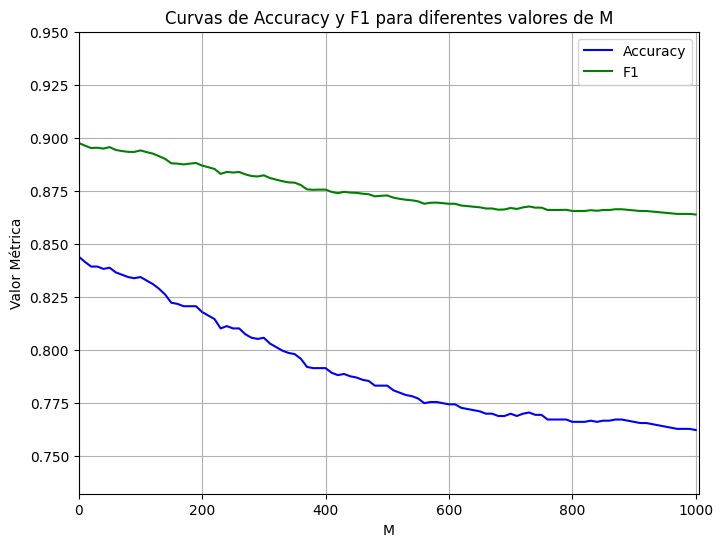

In [ ]:
funciones.plot_metricas(resultados,1000)

Viendo que el mejor m ocurre en los primeros valores, a continuación se aplica el mismo método, restringido al rango 1-10, utilizando saltos de 1.

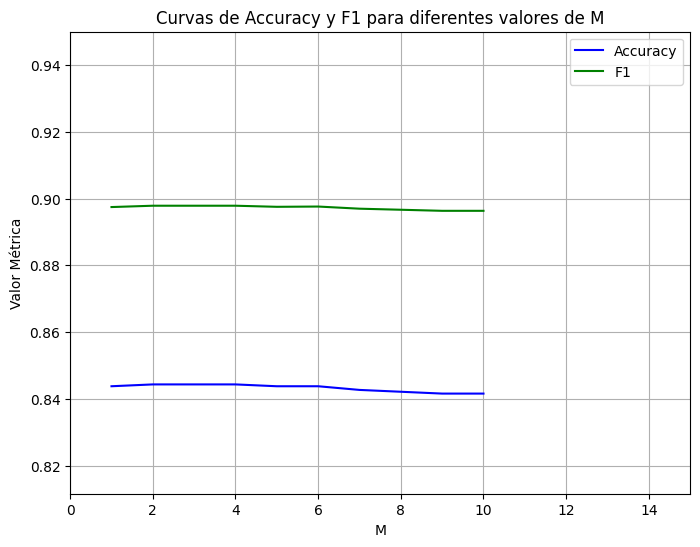

In [ ]:
m_posibles = list(range(1, 11, 1))
resultados_10 = {}

for m in m_posibles:
    resultados_10[m] = funciones.validacion_cruzada(X_train, Y_train, m, atributos_a_categorizar, valores_posibles, 5)

accuracy_scores = [resultados_10[m][0] for m in resultados_10]
mejor_m_accuracy = m_posibles[np.argmax(accuracy_scores)]

f1_scores = [resultados_10[m][3] for m in resultados_10]
mejor_m_f1 = m_posibles[np.argmax(f1_scores)]

funciones.plot_metricas(resultados_10, 10)

De las figuras anteriores se determina que, en general, a medida que m aumenta, las medidas de accuracy y f1 empeoran. 



En particular se reportan los siguientes resultados para $m \in \{1, 10, 100, 1000\}$ :

In [ ]:
df = pd.DataFrame({
    'm': [1, 10, 100, 1000],
    'Accuracy': [resultados[m][0] for m in [1, 10, 100, 1000]],
    'F1 Score': [resultados[m][3] for m in [1, 10, 100, 1000]]
})

print(df)

      m  Accuracy  F1 Score
0     1    0.8438    0.8975
1    10    0.8416    0.8963
2   100    0.8344    0.8941
3  1000    0.7624    0.8639


In [ ]:
print(f"El valor de m que maximiza la accuracy es: {mejor_m_accuracy}, con un valor de: {accuracy_scores[mejor_m_accuracy]}")
print(f"El valor de m que maximiza el f1 es: {mejor_m_f1}, con un valor de: {f1_scores[mejor_m_f1]}")

El valor de m que maximiza la accuracy es: 2, con un valor de: 0.8443359670632399
El valor de m que maximiza el f1 es: 2, con un valor de: 0.8978698403020292


### 3.2 Selección de atributos

A continuación, se llama a la función `seleccionar_subconjunto_a_eliminar`, la cuál itera sobre todos los subconjuntos del arreglo `potenciales_atributos_a_eliminar`, y aplica validación cruzada sobre todos los conjuntos de entrenamiento resultantes para obtener el subconjunto que de los mejores resultados en relación al m que dio el mejor f1.

In [ ]:
atributos_a_eliminar, accuracy_maximo, f1_maximo = funciones.seleccionar_subconjunto_a_eliminar(X_train, Y_train, mejor_m_f1, potenciales_atributos_a_eliminar, valores_posibles, atributos_a_categorizar)
print(f'El subconjunto óptimo para eliminar es: {atributos_a_eliminar}')
print(f'El accuracy obtenido al eliminar este subconjunto es: {accuracy_maximo}')
print(f'El f1 obtenido al eliminar este subconjunto es: {f1_maximo}')

El subconjunto óptimo para eliminar es: ('wtkg', 'hemo', 'oprior', 'preanti', 'cd820')
El accuracy obtenido al eliminar este subconjunto es: 0.8470877607241244
El f1 obtenido al eliminar este subconjunto es: 0.899707567115555


### 3.3. Resultados de validación

Dados los resultados obtenidos en la etapa de validación cruzada y la selección de atributos según el $m$ óptimo, las mejores métricas se dan con $m = 2$ y eliminando el conjunto de atributos $ \{wtkg,hemo,oprior,preanti,cd820\}$. 

En particular, la mejora de la eliminación del conjunto es del orden del 0.3% en _accuracy_ y del 0.2% en _f1_. 

A modo de resumen, se reportan los siguientes resultados, que recolectan la información relevante de la etapa experimental:

<table style="margin: 0px auto;">
  <tr>
    <th>Valor de m</th>
    <th>Accuracy</th>
    <th>F1</th>
  </tr>
  <tr>
    <td>1</td>
    <td>0.84379</td>
    <td>0.89747</td>
  </tr>
  <tr>
    <td style="font-weight:bold">2</td>
    <td style="font-weight:bold">0.84433</td>
    <td style="font-weight:bold" >0.89787</td>
  </tr>
  <tr>
    <td>10</td>
    <td>0.84159</td>
    <td>0.89634</td>
  </tr>
  <tr>
    <td>100</td>
    <td>0.83444</td>
    <td>0.89408</td>
  </tr>
  <tr>
    <td>1000</td>
    <td>0.76238</td>
    <td>0.86391</td>
  </tr>
</table>

<table style="margin: 0px auto;">
  <tr>
    <th>Seleccion de atributos</th>
    <th>Accuracy</th>
    <th>F1</th>
  </tr>
  <tr>
    <td>Sin seleccion</td>
    <td>0.84433</td>
    <td>0.89787</td>
  </tr>
  <tr>
    <td>('wtkg', 'hemo', 'oprior', 'preanti', 'cd820')</td>
    <td style="font-weight:bold">0.84709</td>
    <td style="font-weight:bold" >0.89971</td>
  </tr>
  </tr>
</table>

## 4. Evaluación

### 4.1. Métricas generales

Se calculan y reportan las métricas _«accuracy»_, «f1-score», _«precision»_ y _«recall»_ para el conjunto de evaluación:

In [ ]:
discretizer = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy='kmeans', subsample=200_000, random_state=12345)

X_train_copy = X_train.copy().drop(columns=list(atributos_a_eliminar))
X_test_copy = X_test.copy().drop(columns=list(atributos_a_eliminar))

# Se eliminan los valores necesarios de "valores_posibles" y "atributos_a_categorizar"
valores_posibles_aux = valores_posibles.copy()
atributos_a_categorizar_aux = atributos_a_categorizar.copy()
for key in atributos_a_eliminar:
    valores_posibles_aux.pop(key)
    if key in atributos_a_categorizar_aux:
        atributos_a_categorizar_aux.remove(key)

# Se calculan los puntos de corte para X_train
puntos_corte = {}
for atributo in atributos_a_categorizar_aux:
    X_train_copy[atributo] = discretizer.fit_transform(X_train_copy[[atributo]]).astype(int)
    puntos_corte[atributo] = discretizer.bin_edges_[0][1:3]
    valores_posibles_aux[atributo] = np.unique(X_train_copy[atributo])

# Se aplican los mismos puntos de corte para X_test
for atributo in atributos_a_categorizar_aux:
    X_test_copy[atributo] = np.digitize(X_test_copy[atributo], puntos_corte[atributo]).astype(int)

modelo_test = funciones.NaiveBayesAIDS(mejor_m_f1, valores_posibles_aux)
modelo_test.fit(X_train_copy, Y_train)
Y_pred = modelo_test.predict(X_test_copy)

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_test, Y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.8473520249221184
Precision: 0.907563025210084
Recall: 0.8888888888888888
F1: 0.8981288981288981


### 4.2 Curva de Precision-Recall

Se grafican las curvas de _«precision-recall»_ para el conjuntos de evaluación, utilizando tanto el eje x como umbral, como también para recall, comparando la evolución de la precision y el recall, y calculando el AP (average precision).

Umbral donde se da el cruce: 0.46147999822035685


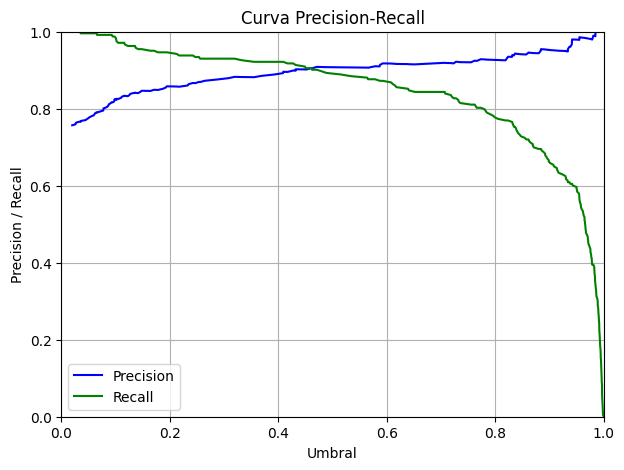

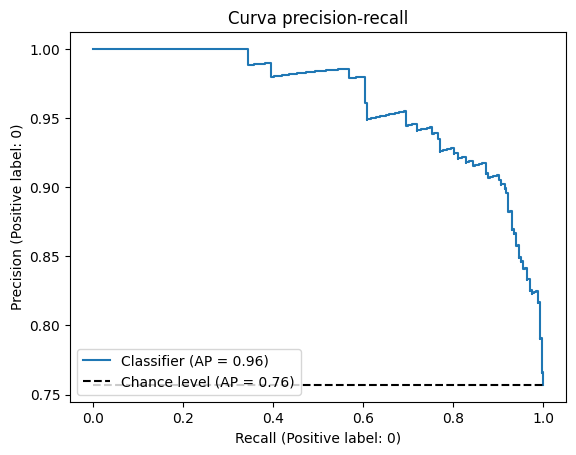

In [ ]:
funciones.curva_precision_recall(modelo_test, X_test_copy, Y_test)

probs_clase_0 = modelo_test.predict_proba(X_test_copy)
probs_clase_0 = [p[0] for p in probs_clase_0]

display = PrecisionRecallDisplay.from_predictions(
    Y_test, probs_clase_0, plot_chance_level=True, pos_label=0
)
_ = display.ax_.set_title("Curva precision-recall")


#### 4.2.1. Curva de Precision-Recall con probabilidad logarítmica

A continuación se repite la obtención de métricas pero utilizando la clasificación logarítmica. Se observa que generar esta curva es más complejo que el caso anterior, dado que la variable independiente no puede ser el umbral de probabilidad, ya que aplicar logaritmo. Para esto se modifica la clase `NaiveBayesAIDS` para que permita devolver las probabilidades logarítmicas.

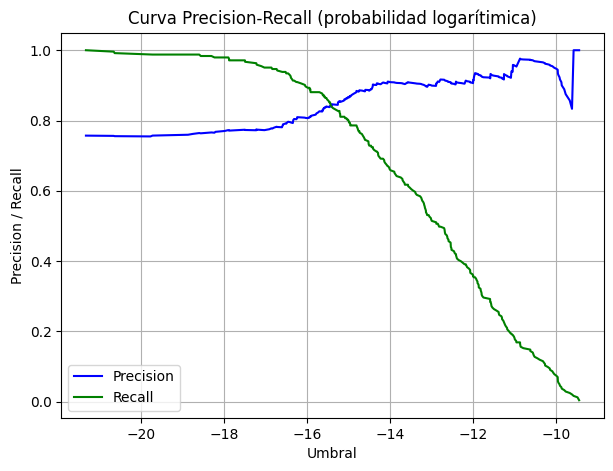

Umbral donde se da el cruce: -15.407981809089115


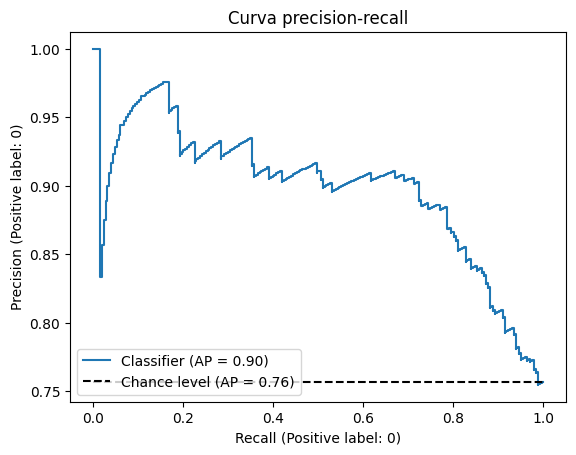

In [ ]:
funciones.curva_precision_recall_log(modelo_test, X_test_copy, Y_test)

logs_clase_0 = modelo_test.predict_proba_log(X_test_copy)
logs_clase_0 = [p[0] for p in logs_clase_0]

display = PrecisionRecallDisplay.from_predictions(
    Y_test, logs_clase_0, plot_chance_level=True, pos_label=0
)
_ = display.ax_.set_title("Curva precision-recall")

#### 4.2.2 Análisis comparativo de ambas curvas

En ambos casos, vemos como el cruce se da, aproximadamente, en el valor intermedio del umbral, lo cual se corresponde con el caso en el cual se predice la clase de mayor probabilidad.
Además, si bien el uso de logaritmos permite evitar inestabilidad numérica, esto provoca también que, al graficar las curvas precision-recall, se vea un comportamiento distinto y mas inestable, reduciendo el valor del AP.


### 4.3 Matríz de confusión

La matriz de confusión esclarece los resultados de la clasificación, al mostrar la siguiente distribución de valores:

- Verdaderos positivos: $TP = 216$ 
- Verdaderos negativos: $TN = 56$
- Falsos positivos: $FP = 27$
- Falsos negativos: $FN = 22$

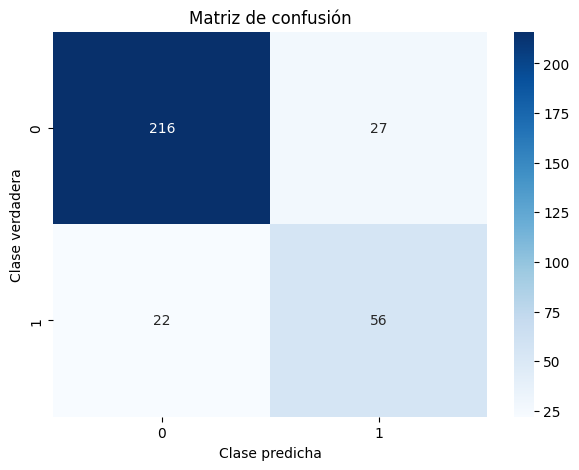

In [ ]:
funciones.plot_confusion_matrix(Y_test, Y_pred)

### 4.5 Comparación con antecedentes

#### 4.5.1 Resultados de implementaciones anteriores

Previo a la evaluación, se reportan los resultados obtenidos en el laboratorio anterior, donde se realizó un predictor utilizando árboles de decisión generados con el algoritmo ID3, y sus resultados fueron comparados con los de bibliotecas conocidas (`scikit-learn`). Para facilitar la lectura, se agrega también el resultado del predictor bayesiano a la tabla.

In [ ]:
resultados = pd.read_csv('antecedentes/resultados_lab1.csv')

resultado_naive_bayes = pd.DataFrame({
    'Modelo': ['Naive Bayes'],
    'Accuracy': [accuracy],
    'F1': [f1]
})
resultados = pd.concat([resultados, resultado_naive_bayes], ignore_index=True)
print(resultados)

             Modelo  Accuracy     F1
0  Predictor Simple    0.7600 0.8600
1            Manual    0.8411 0.8952
2    Arbol Libreria    0.8600 0.9000
3     Random Forest    0.9000 0.9300
4       Naive Bayes    0.8474 0.8981


#### 4.5.2 Comparación

Se observa que la implementación del algoritmo de «Naïve Bayes» superó la implementación del alogritmo «ID3» en 0.75% para la _«accuracy»_ y 0.3% para la _«f1-score»_.

## 5. Conclusiones

A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando Naive Bayes, aprovechando herramientas de metodología para profundizar el análisis de rendimiento y tomar decisiones en base a ellas.

Los resultados muestran una mejoría de esta estrategia por sobre las utilizadas anteriormente del orden de entre 0.3% y 0.75% dependiendo de la métrica observada.

También, se desprenden las siguientes conclusiones particulares:

- El uso de la técnica $m$-estimador ayudó a mitigar los casos de probabilidad cero.

- Sin embargo, la búsqueda del mejor $m$ llevó a encontrar la tendencia que a mayor $m$, peor _accuracy_ y _f1_.

- Una posible razón por la cuál el algoritmo funciona mejor con $m$ pequeños, es que son muy pocos los _«eventos de probabilidad cero»_ que hay que mitigar, esto lleva a que exagerar el tamaño del $m$ castiga a los eventos cuya probabilidad es mayor que cero, que son mayoritarios en el contexto de este trabajo.

- Sobre el proceso de selección de atributos, se concluye que no se presenta una mejora lo suficientemente sustantiva como para justificar el tiempo de cómputo para encontrar el subconjunto a eliminar.

Como mejora a futuro se podría:
- Utilizar algoritmos de búsqueda de hiperparámetros como _«Grid Search»_ o _«Random Search»_, tal como fue justificado en la sección 2.6.

- Utilizar la librería _«scikit-learn»_ para implementar el algoritmo de _«Naïve Bayes»_, esto no se hizo en el entendido que no era el espíritu del laboratorio (por ejemplo, en el laboratorio anterior se pide específicamente).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c37fbc8c-fee1-4291-8075-be0e33896680' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>